In [1]:
! pip install -U langgraph langsmith
! pip install langchain_community
! pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.7/339.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.11
    Uninstalling langsmith-0.3.11:
      Successfully uninstalled langsmith-0.3.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninst

In [19]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END ,state
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import os

In [21]:
import os
from langchain_openai import ChatOpenAI

os.environ['OPENAI_API_KEY'] = "sk-proj- "

llm_ThoT = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

### Building Prompt Generator Agents Based on "The Prompt Report: A Systematic Survey of Prompting Techniques."

### **Goal**

The main idea is to develop automated **prompt generator agents**. These agents will be designed to:

* Analyze a given question.
* Generate an optimized prompt using various prompting techniques.

The development of these agents relies on:

* Recent prompt techniques, defined and classified in the document **"The Prompt Report: A Systematic Survey of Prompting Techniques"**.

### **Functionality**

1.  **Question Reception:** The agent receives a question as input.
2.  **Question Analysis:** The agent analyzes the question to understand its intent and requirements.
3.  **Prompt Approach Selection:** Based on the analysis and the techniques from "The Prompt Report," the agent selects the most appropriate prompting approach.
4.  **Prompt Generation:** The agent generates an optimized prompt using the selected approach.

### **Expected Benefits**

* Facilitate the creation of complex prompts.
* Optimize the efficiency of AI models.
* Make the use of AI more accessible.

In [27]:
# ThoT Prompt
thot_prompt_template = ChatPromptTemplate.from_messages([
    ("system", """
    Generate Thread-of-Thought (ThoT) prompts based on user questions.
    (ThoT) is a part of Chain-of-Thought (CoT) prompting leverages few-shot prompting to encourage the LLM to express its thought process before delivering its final answer.
    This technique enhances the LLM’s performance in reasoning tasks.
    A CoT prompt includes an exemplar featuring a question, a reasoning path, and the correct answer.
    Thread-of-Thought (ThoT) is a specialized form of CoT.
    The ThoT process includes the following steps:
    1. High-level prompt: "Walk me through this context in manageable parts step by step, summarizing and analyzing as we go."
    2. Summarize and analyze: Break down the question's context into manageable parts, summarizing and analyzing each part.
    3. Answer the original question: Provide a final answer based on the analysis.

    Please structure your response in the following format:

    Step 1: [High-level prompt]
    Step 2: [Summarize and analyze each part]
    Step 3: [Final Answer]

    Example:
    Question: "What are the main causes of climate change?"
    Step 1: Walk me through this context in manageable parts step by step, summarizing and analyzing as we go.
    Step 2: The main causes of climate change include the burning of fossil fuels, deforestation, and industrial activities. These activities release greenhouse gases like carbon dioxide and methane into the atmosphere, which trap heat and cause global temperatures to rise.
    Step 3: The main causes of climate change are the burning of fossil fuels, deforestation, and industrial activities, which release greenhouse gases that trap heat in the atmosphere.
    """),
    ("human", "{question}"),
    ("assistant", """
    Walk me through this context in manageable parts step by step, summarizing and analyzing as we go:
    ... (Detailed reasoning and analysis here, following the ThoT example) ...

    Final Answer: ...
    """)
])

In [28]:
# generate prompt ThoT (node)
def generate_thot_node(state):
    question = state['messages'][-1].content  # Récupère la dernière question
    prompt_value = thot_prompt_template.invoke({"question": question})
    messages = prompt_value.to_messages()
    response = llm_ThoT.invoke(messages)
    return {"messages": [response]}  # Ajoute la réponse comme un message


In [29]:
# Graph création
graph_builder = StateGraph(State)
graph_builder.add_node("generate_thot", generate_thot_node)

# Graph configuration
graph_builder.set_entry_point("generate_thot")
graph_builder.add_edge("generate_thot", END)
graph = graph_builder.compile()

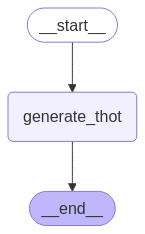

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
# Exemple
inputs = {"messages": [HumanMessage(content="What are the main causes of financial crisis of 1929 ?")]}
for output in graph.stream(inputs):
    for key, value in output.items():
        if key == "generate_thot":
            messages = value['messages']
            for message in messages:
                if isinstance(message, AIMessage):
                    print(message.content) # Affiche uniquement le contenu du message de l'IA

Step 1: Walk me through this context in manageable parts step by step, summarizing and analyzing as we go.

Step 2: The financial crisis of 1929, also known as the Great Depression, had several main causes. First, there was excessive speculation in the stock market during the 1920s, where investors bought stocks on margin, meaning they borrowed money to invest. This created an unsustainable bubble. Second, the economy was experiencing overproduction, particularly in agriculture and manufacturing, leading to a surplus of goods that could not be sold. Third, there was a lack of regulation in the banking sector, which allowed for risky lending practices. Additionally, international trade was affected by tariffs, such as the Smoot-Hawley Tariff, which reduced global trade and worsened the economic situation. Finally, the stock market crash in October 1929 triggered a loss of confidence, leading to bank runs and further economic decline.

Step 3: The main causes of the financial crisis of 1